# Auto ML

In [18]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.plot as plot 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [19]:
augmented_df = pd.read_csv('data/241210_augmented_250m.csv')
train_df = pd.read_csv('data/241209_Rockhead_Seoul_train(before_aumentation).csv')
test_df = pd.read_csv('data/241209_Rockhead_Seoul_test(before_aumentation).csv')

In [20]:
augmented_df['rock_type'] = augmented_df['type_num'].astype('category')
augmented_df = augmented_df[['X', 'Y', 'DEM', 'Slope', 'Aspect', 'rock_type', 'R2_weight']]

# one-hot encoding
augmented_df = pd.get_dummies(data=augmented_df, drop_first=True)

# rename
augmented_df.rename(columns={'X': 'x', 'Y':'y', 'Slope': 'slope', 'Aspect':'aspect', 'R2_weight':'depth_start'}, inplace=True)

# drop
train_df = train_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)
test_df = test_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)

# column set
augmented_df = augmented_df[train_df.columns]

In [21]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              9693 non-null   float64
 1   y              9693 non-null   float64
 2   depth_start    9347 non-null   float64
 3   slope          9693 non-null   float64
 4   aspect         9693 non-null   float64
 5   DEM            9693 non-null   float64
 6   rock_type_1.0  9693 non-null   bool   
 7   rock_type_2.0  9693 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 473.4 KB


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              11144 non-null  float64
 1   y              11144 non-null  float64
 2   depth_start    11144 non-null  float64
 3   slope          11144 non-null  float64
 4   aspect         11144 non-null  float64
 5   DEM            11144 non-null  float64
 6   rock_type_1.0  11144 non-null  bool   
 7   rock_type_2.0  11144 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 544.3 KB


In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   float64
 5   DEM            3183 non-null   float64
 6   rock_type_1.0  3183 non-null   bool   
 7   rock_type_2.0  3183 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 155.5 KB


C:\Users\mijin\AppData\Local\Temp\ipykernel_27612\262103387.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy])


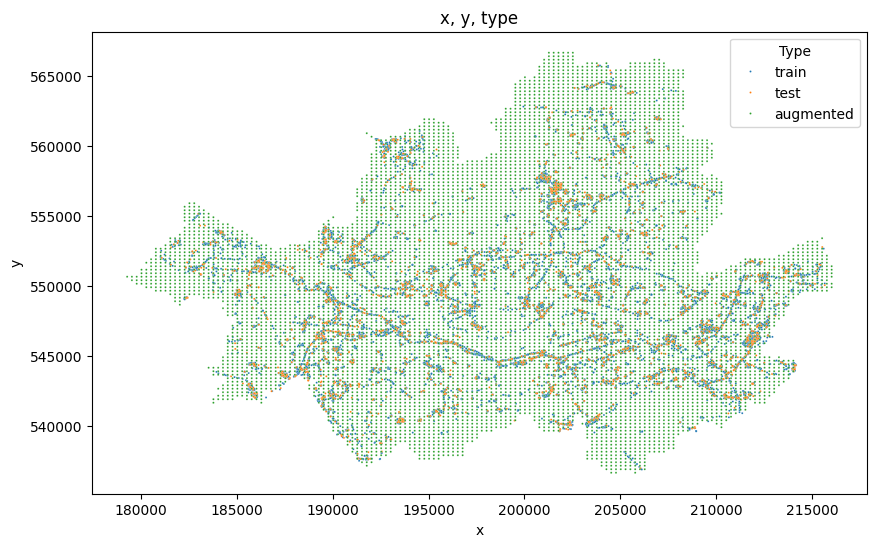

In [26]:
train_df_copy = train_df.copy()
augmented_df_copy = augmented_df.copy()
test_df_copy = test_df.copy()

augmented_df_copy['Type'] = 'augmented'
train_df_copy['Type'] = 'train'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy])

plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

In [28]:
train_df = pd.concat([train_df, augmented_df])
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20837 entries, 0 to 9692
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              20837 non-null  float64
 1   y              20837 non-null  float64
 2   depth_start    20491 non-null  float64
 3   slope          20837 non-null  float64
 4   aspect         20837 non-null  float64
 5   DEM            20837 non-null  float64
 6   rock_type_1.0  20837 non-null  bool   
 7   rock_type_2.0  20837 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   flo

## Pre-Processing

In [29]:
# Min Max Scaling: x, y, slope, DEM
column_to_scale = ['x', 'y', 'slope', 'aspect', 'DEM']

scaler = MinMaxScaler()

# train_dataset
train_df[column_to_scale] = scaler.fit_transform(train_df[column_to_scale])
train_df['depth_start'] = train_df['depth_start']

# test_dataset
test_df[column_to_scale] = scaler.fit_transform(test_df[column_to_scale])
test_df['depth_start'] = test_df['depth_start']

display(train_df.describe())
display(test_df.describe())

,x,y,depth_start,slope,aspect,DEM
count,20837.000000,20837.000000,20491.000000,20837.000000,20837.000000,20837.000000
mean,0.547210,0.432474,10.052181,0.062335,0.500760,0.061569
std,0.217937,0.204209,7.153731,0.102976,0.289207,0.090129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.374150,0.271111,4.500000,0.012417,0.249647,0.017765
50%,0.579342,0.416714,7.980927,0.013649,0.510293,0.032204
75%,0.714286,0.560078,15.493571,0.057043,0.754841,0.064620
max,1.000000,1.000000,62.300000,1.000000,1.000000,1.000000


,x,y,depth_start,slope,aspect,DEM
count,3183.000000,3183.000000,3183.000000,3183.000000,3183.000000,3183.000000
mean,0.531491,0.422672,10.724684,0.511013,0.497876,0.127330
std,0.230834,0.191999,7.733756,0.078886,0.290860,0.116840
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.335941,0.270487,4.500000,0.486200,0.237334,0.051460
50%,0.577414,0.409071,9.000000,0.518532,0.507326,0.082139
75%,0.699274,0.533633,16.500000,0.539338,0.757514,0.164819
max,1.000000,1.000000,52.700000,1.000000,1.000000,1.000000


C:\Users\mijin\AppData\Local\Temp\ipykernel_27612\4247111795.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df, test_df])


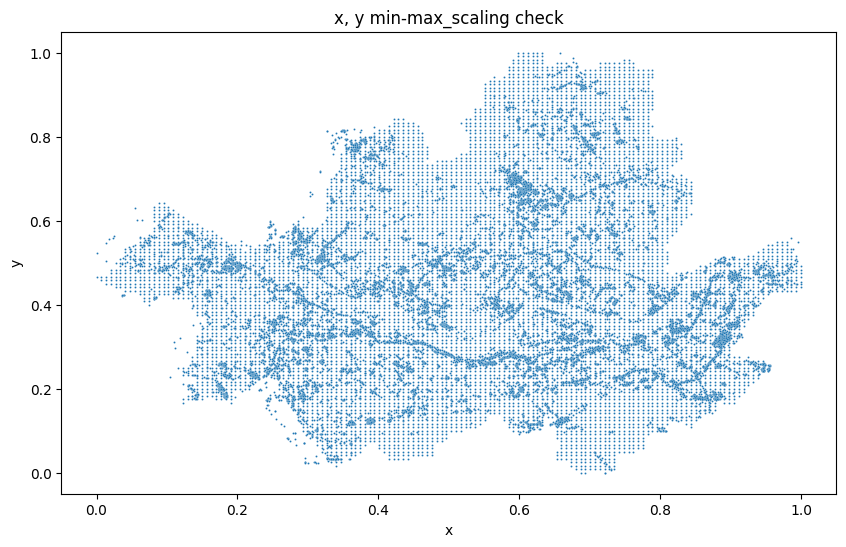

In [30]:
df_concat = pd.DataFrame(columns=train_df.columns)
df_concat = pd.concat([df_concat, train_df, test_df])
plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y min-max_scaling check')

In [32]:
train = TabularDataset(train_df)
test = TabularDataset(test_df)
X_test = TabularDataset(test_df.drop(['depth_start'], axis=1))
y_test = test_df['depth_start'].values.tolist()

## Training-Validation

In [33]:
predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2 
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 3600*24, 
              presets="best_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = True,
              ag_args_fit = {'num_gpus': 1} # Train with GPU, # 140 models without gpu, 84 models with gpu during 3600*10(241026), 120 models with gpu during 3600*14(241028)
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20241210_163306"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          22
Memory Avail:       45.87 GB / 63.61 GB (72.1%)
Disk Space Avail:   686.98 GB / 951.65 GB (72.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

ValueError: Label column cannot contain non-finite values (NaN, Inf, Ninf). First invalid label at train_data idx: 17

In [ ]:
ld_board = predictor.leaderboard(test, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,0.576036,0.711311,r2,0.094911,0.094518,0.035506,0.094911,0.094518,0.035506,1,True,2
1,KNeighborsUnif_BAG_L1,0.571068,0.667409,r2,0.082492,0.074081,0.051518,0.082492,0.074081,0.051518,1,True,1
2,ExtraTrees_r49_BAG_L1,0.481314,0.758826,r2,2.394392,0.535094,0.888658,2.394392,0.535094,0.888658,1,True,54
3,XGBoost_r98_BAG_L1,0.480137,0.745965,r2,6.427258,1.868768,444.490281,6.427258,1.868768,444.490281,1,True,47
4,LightGBM_r121_BAG_L1,0.476933,0.753757,r2,2.171386,2.555453,842.184119,2.171386,2.555453,842.184119,1,True,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NeuralNetTorch_r185_BAG_L1,0.306093,0.657613,r2,0.510091,0.095517,529.626082,0.510091,0.095517,529.626082,1,True,76
111,NeuralNetTorch_r89_BAG_L1,0.305942,0.617243,r2,0.345175,0.093013,443.878717,0.345175,0.093013,443.878717,1,True,108
112,NeuralNetTorch_r36_BAG_L1,0.296994,0.546043,r2,0.282051,0.090013,393.415435,0.282051,0.090013,393.415435,1,True,98
113,NeuralNetTorch_r22_BAG_L1,0.294602,0.670353,r2,0.647125,0.081511,490.080850,0.647125,0.081511,490.080850,1,True,18


## Prediction

In [ ]:
pred_y = predictor.predict(X_test, ld_board.model[1])

In [ ]:
mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  3.335306577629583
mse:  21.714925220458227
rmse:  4.659927598199164
r2:  0.5710684778681563
